# IEEE-CIS Fraud Detection — EDA + LSTM (sequências temporais)

**Objetivo:**
1) Carregar o dataset,
2) Fazer EDA (distribuições, correlações, outliers),
3) Preparar dados em formato sequencial para um LSTM,
4) Treinar/validar com métricas (Precision, Recall, F1, AUC-ROC) e
5) Analisar resultados/overfitting.

**Notas:**
- Vamos juntar `train_transaction.csv` + `train_identity.csv` (chave: `TransactionID`).
- Sequências por “usuário proxy” = grupo (`card1`, `addr1`) ordenado por `TransactionDT`.
- Janela (sequence_length) = 10 (ajustável).
- Tratamento de nulos, normalização robusta e *class weights* para desbalanceamento.


In [1]:

import os, zipfile, glob, pandas as pd
import time


os.makedirs('/root/.kaggle', exist_ok=True)

if os.path.exists('/content/kaggle.json'):
    !mv -f /content/kaggle.json /root/.kaggle/kaggle.json
    !chmod 600 /root/.kaggle/kaggle.json
    time.sleep(1)

    # Baixa e descompacta a competição
    !kaggle competitions download -c ieee-fraud-detection
    !unzip -qo /content/ieee-fraud-detection.zip -d /content/ieee

    # Lista arquivos baixados
    print(sorted(glob.glob('/content/ieee/*')))
else:
    print("kaggle.json not found. Please upload it first.")

ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
['/content/ieee/sample_submission.csv', '/content/ieee/test_identity.csv', '/content/ieee/test_transaction.csv', '/content/ieee/train_identity.csv', '/content/ieee/train_transaction.csv']


## Carregamento dos dados e junção

- Ler `train_transaction.csv` e `train_identity.csv`.
- Fazer **merge** por `TransactionID`.
- Conversão de `TransactionDT` em tempo relativo legível e criação de features temporais (dia/hora/dia-da-semana).


In [2]:
import numpy as np

PATH = '/content/ieee'
train_tr = pd.read_csv(f'{PATH}/train_transaction.csv')
train_id = pd.read_csv(f'{PATH}/train_identity.csv')

# Merge
df = train_tr.merge(train_id, on='TransactionID', how='left')

# TransactionDT é um "segundo relativo" ao primeiro timestamp; vamos criar um datetime arbitrário
START_DATE = pd.Timestamp('2017-12-01')
df['TransactionDT_datetime'] = START_DATE + pd.to_timedelta(df['TransactionDT'], unit='s')

# Features temporais
df['hour'] = df['TransactionDT_datetime'].dt.hour
df['day'] = (df['TransactionDT'] // (24*60*60)).astype(int)
df['dow'] = df['TransactionDT_datetime'].dt.dayofweek

# Alvo
target = 'isFraud'

df.shape, df[target].mean()


((590540, 438), np.float64(0.03499000914417313))

## EDA — Visão geral e valores ausentes

- Dimensões do dataset.
- Proporção de fraude (desbalanceamento).
- Tabela de **missing values** (top 25).


In [3]:
print("Shape:", df.shape)
print("Fraude (positivos %):", df['isFraud'].mean()*100)


na_ratio = df.isna().mean().sort_values(ascending=False)
na_top = na_ratio.head(25).to_frame('na_ratio')
na_top


Shape: (590540, 438)
Fraude (positivos %): 3.4990009144173126


,na_ratio
id_24,0.991962
id_25,0.991310
id_08,0.991271
id_07,0.991271
id_21,0.991264
id_26,0.991257
id_22,0.991247
id_27,0.991247
id_23,0.991247
dist2,0.936284


### EDA — Distribuições e outliers (amostra)

- Histograma de `TransactionAmt` (linear e log).
- Boxplot para visualizar outliers em `TransactionAmt`.
- Distribuição de `isFraud` por hora/dia da semana (tendências temporais).


Text(0.5, 1.0, 'Taxa de fraude por dia da semana')

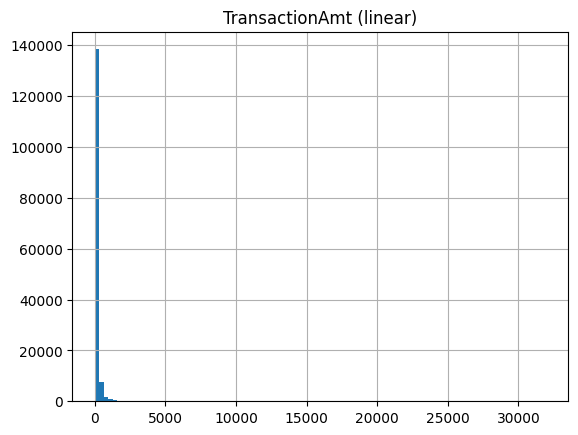

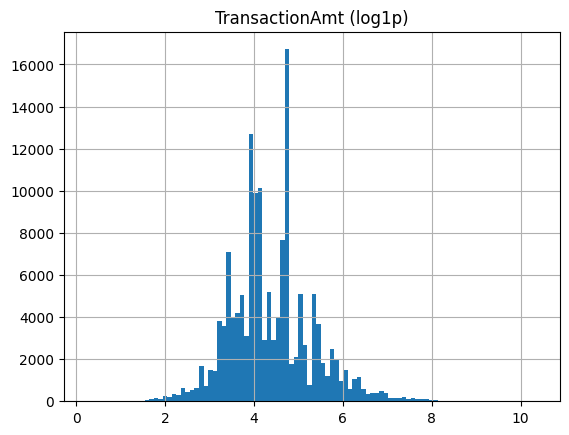

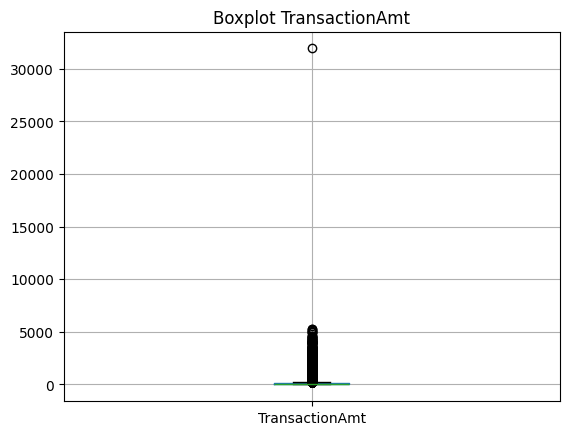

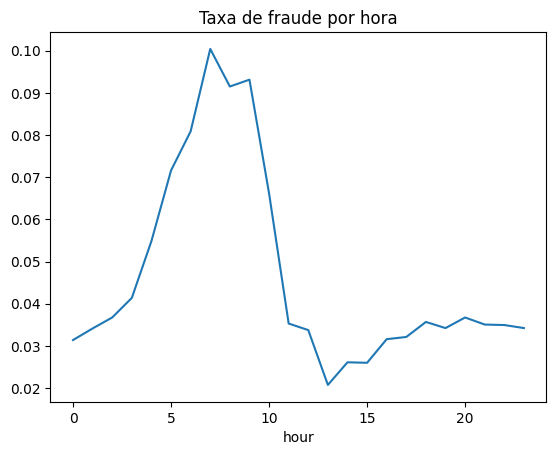

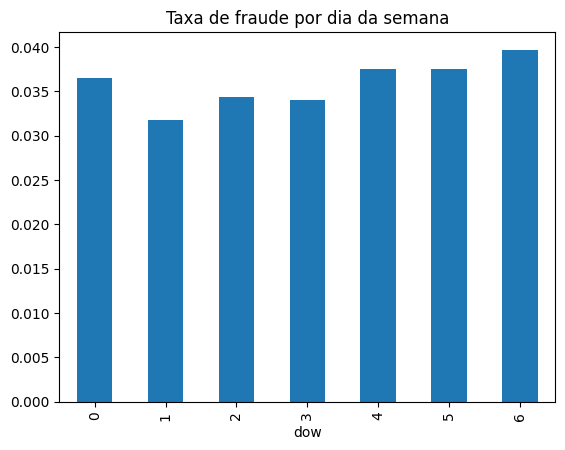

In [4]:
import matplotlib.pyplot as plt

sample = df.sample(150_000, random_state=42) if len(df) > 150_000 else df.copy()

plt.figure()
sample['TransactionAmt'].hist(bins=100)
plt.title('TransactionAmt (linear)')

plt.figure()
np.log1p(sample['TransactionAmt']).hist(bins=100)
plt.title('TransactionAmt (log1p)')

plt.figure()
sample.boxplot(column='TransactionAmt')
plt.title('Boxplot TransactionAmt')

plt.figure()
sample.groupby('hour')['isFraud'].mean().plot()
plt.title('Taxa de fraude por hora')

plt.figure()
sample.groupby('dow')['isFraud'].mean().plot(kind='bar')
plt.title('Taxa de fraude por dia da semana')


### EDA — Correlações (numéricas)

- Para evitar travar o Colab, calculamos **apenas a correlação de cada feature com `isFraud`** (em vez da matriz completa).
- Usamos **amostra de 200.000 linhas**, removemos **colunas constantes** e convertemos para `float32` para reduzir RAM.
- A correlação foi feita com `corrwith` (Pearson), e exibimos as **top-20 por |correlação|**.


,corr_isFraud
V40,0.180047
V45,0.182052
V51,0.186062
V243,0.191100
V52,0.199420
V190,0.201988
V230,0.202317
V171,0.208354
V199,0.218440
V228,0.222910


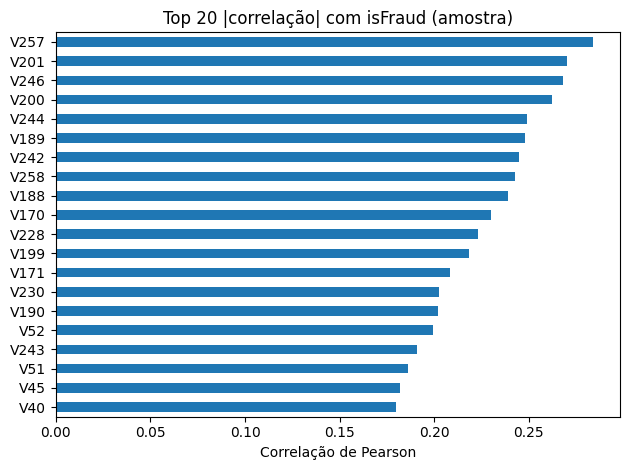

In [5]:

TARGET = 'isFraud'
SAMPLE_N = 200_000

# 1) Amostra
sample = df.sample(SAMPLE_N, random_state=42) if len(df) > SAMPLE_N else df

# 2) Seleciona numéricas e prepara X/y
num_cols = sample.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

X = sample[num_cols].copy()

# remove colunas totalmente nulas ou constantes
const_mask = (X.nunique(dropna=True) <= 1)
if const_mask.any():
    X = X.loc[:, ~const_mask]
    num_cols = X.columns.tolist()

# fillna e downcast
X = X.fillna(0).astype('float32')
y = sample[TARGET].astype('float32')

# 3) Correlação (Pearson) de forma vetorizada
corrs = X.corrwith(y)

# 4) Top 20 por |correlação|
top20_idx = corrs.abs().sort_values(ascending=False).head(20).index
top20 = corrs[top20_idx].sort_values(key=np.abs, ascending=True)  # ordena p/ plot vertical

display(top20.to_frame('corr_isFraud'))

# 5) Barplot
plt.figure()
top20.plot(kind='barh')
plt.title('Top 20 |correlação| com isFraud (amostra)')
plt.xlabel('Correlação de Pearson')
plt.tight_layout()
plt.show()

## Preparação de dados para LSTM

**Por que LSTM?** O dataset é transacional com eixo temporal (`TransactionDT`). Vamos modelar **sequências por usuário proxy** (`card1` + `addr1`) e prever fraude na **última transação da janela**.

**Estratégia prática (otimizada para RAM):**
- Selecionamos **features numéricas mais relevantes** (top-20 pela |correlação| com `isFraud`).
- Preenchemos nulos com `0` (estratégia simples para LSTM) e usamos **RobustScaler**.
- Construímos janelas de comprimento **`sequence_length = 10`**.
- **Split temporal**: último 20% do tempo para validação.
- **Desbalanceamento**: uso de `class_weight` no treino.


In [6]:
# Correlação rápida: cada feature x isFraud
import numpy as np
import pandas as pd

# 1) Amostra para acelerar (ajuste se quiser mais/menos)
sample = df.sample(200_000, random_state=42) if len(df) > 200_000 else df

# 2) Seleciona numéricas e converte pra float32 (menos RAM)
num_cols = sample.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'isFraud']
X = sample[num_cols].astype('float32')
y = sample['isFraud'].astype('float32')

# 3) Correlação com o alvo (Pearson) de forma vetorizada
# corrwith é bem mais leve que df.corr() completo
corrs = X.corrwith(y)

# 4) Top 20 por valor absoluto
top20 = corrs.abs().sort_values(ascending=False).head(20)
top20 = corrs[top20.index]  # reordena mantendo sinal

display(top20.to_frame('corr_isFraud'))


,corr_isFraud
V257,0.373806
V244,0.355613
V246,0.354539
V242,0.353216
V201,0.321869
V200,0.309298
V189,0.300264
V258,0.294641
V188,0.291097
V158,0.284115


### Preparação de dados: `user_id`, seleção de features e escalonamento

- `user_id` = `card1|addr1`.
- **Seleção de features**: usamos as **top-20** com maior |correlação| com `isFraud` (obtidas na etapa anterior).
- **Tratamento**: `fillna(0)` e conversão para `float32`.
- **Escalonamento**: `RobustScaler` para reduzir efeito de outliers.
- Metadados: `meta = [user_id, TransactionDT]` para controlar a ordem temporal.


In [8]:
from sklearn.preprocessing import RobustScaler

# Criar user_id
df['user_id'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)

# Selecionar top N features numéricas (baseado na correlação absoluta calculada anteriormente)
# Use as top 20 features do passo de EDA de correlação
num_feats = top20.index.tolist()
print(f'Usando {len(num_feats)} features numéricas: {num_feats}')

# Preencher nulos e escalonar
X = df[num_feats].fillna(0).astype('float32')
y = df[target].astype('float32')

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Criar meta dataframe para user_id e TransactionDT
meta = df[['user_id', 'TransactionDT']].copy()

print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)
print("meta shape:", meta.shape)

Usando 20 features numéricas: ['V257', 'V244', 'V246', 'V242', 'V201', 'V200', 'V189', 'V258', 'V188', 'V158', 'V45', 'V149', 'V156', 'V228', 'V44', 'V86', 'V170', 'V87', 'V147', 'V52']
X_scaled shape: (590540, 20)
y shape: (590540,)
meta shape: (590540, 2)


###  Construção das sequências
Para evitar “out of RAM”:
- Limitamos o volume processado com **parâmetros de proteção**:
  - `MAX_ROWS` (linhas consideradas),
  - `MAX_USERS` (número de usuários),
  - `MAX_WINDOWS` (quantidade total de janelas),
  - `STRIDE` (passo entre janelas; maior ⇒ menos janelas).
- Ordenamos por `TransactionDT` e criamos janelas deslizantes de tamanho **10**.
- O **rótulo** de cada janela é `isFraud` da **última transação**.
- **Split temporal** via `cut_time` (percentil 80 de `TransactionDT`): janelas que terminam **depois** vão para **validação**; as demais ficam no **treino**.


In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd

sequence_length = 10
MAX_ROWS = 300_000
MAX_USERS = 50_000
MAX_WINDOWS = 100_000
STRIDE = 1

# Amostra o dataframe para gerenciar memória
if len(df) > MAX_ROWS:
    df_sampled = df.sample(MAX_ROWS, random_state=42).sort_values('TransactionDT').reset_index(drop=True)
else:
    df_sampled = df.sort_values('TransactionDT').reset_index(drop=True)

# Recriar X_scaled, y, meta com base na amostra
num_feats = top20.index.tolist()
X_sampled = df_sampled[num_feats].fillna(0).astype('float32')
y_sampled = df_sampled[target].astype('float32')
meta_sampled = df_sampled[['user_id', 'TransactionDT']].copy()


# Para split temporal
cut_time = np.percentile(meta_sampled['TransactionDT'], 80)

def build_sequences_optimized(X_df, y_arr_series, meta_df, seq_len=10, cut_time=None, max_users=None, max_windows=None, stride=1):
    X_list_tr, y_list_tr = [], []
    X_list_va, y_list_va = [], []

    # Index por usuário
    user_groups = meta_df.assign(idx=np.arange(len(meta_df))).groupby('user_id')

    all_user_ids = list(user_groups.groups.keys())
    if max_users is not None and max_users < len(all_user_ids):
        user_ids_to_process = np.random.choice(all_user_ids, size=max_users, replace=False)
    else:
        user_ids_to_process = all_user_ids

    window_count = 0
    for user in tqdm(user_ids_to_process, total=len(user_ids_to_process)):
        g = user_groups.get_group(user)
        g = g.sort_values('TransactionDT')
        idxs = g['idx'].values
        if len(idxs) < seq_len:
            continue


        if len(idxs) - seq_len + 1 > 0:
            for start in range(0, len(idxs) - seq_len + 1, stride):
                end = start + seq_len
                window_idx = idxs[start:end]
                if len(window_idx) == seq_len:
                    Xw = X_df.iloc[window_idx].values
                    yw = y_arr_series.iloc[window_idx[-1]]  # rótulo da última transação

                    end_time = meta_df.iloc[window_idx[-1]]['TransactionDT']
                    if cut_time is not None and end_time > cut_time:
                        X_list_va.append(Xw)
                        y_list_va.append(yw)
                    else:
                        X_list_tr.append(Xw)
                        y_list_tr.append(yw)

                    window_count += 1
                    if max_windows is not None and window_count >= max_windows:
                        break # Parar se atingir o número máximo de janelas

            if max_windows is not None and window_count >= max_windows:
                break # Parar se atingir o número máximo de janelas de qualquer usuário


    X_tr = np.array(X_list_tr, dtype=np.float32)
    y_tr = np.array(y_list_tr, dtype=np.int64)
    X_va = np.array(X_list_va, dtype=np.float32)
    y_va = np.array(y_list_va, dtype=np.int64)
    return X_tr, y_tr, X_va, y_va

X_tr, y_tr, X_va, y_va = build_sequences_optimized(
    X_sampled, y_sampled, meta_sampled,
    seq_len=sequence_length,
    cut_time=cut_time,
    max_users=MAX_USERS,
    max_windows=MAX_WINDOWS,
    stride=STRIDE
)

print("X_tr shape:", X_tr.shape)
print("X_va shape:", X_va.shape)
print("y_tr mean:", y_tr.mean())
print("y_va mean:", y_va.mean())

 50%|█████     | 15257/30236 [00:28<00:27, 539.16it/s]


X_tr shape: (75516, 10, 20)
X_va shape: (24484, 10, 20)
y_tr mean: 0.0358202235287886
y_va mean: 0.031612481620650223


## Modelagem LSTM

**Arquitetura:** `LSTM(64) → Dropout(0.2) → LSTM(32) → Dropout(0.2) → Dense(1, sigmoid)`  
**Entrada:** sequências `(seq_len=10, n_features=20)` com `float32`.  
**Treino:** `binary_crossentropy`, `Adam(1e-3)`, `class_weight` balanceado.  
**Callbacks:** `ReduceLROnPlateau(monitor=val_auc)` e `EarlyStopping(monitor=val_auc, restore_best_weights=True)`.  
**Batch size:** 512; **épocas:** até 15 (com early stopping).


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0,1])
cw_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
class_weight = {0: cw_values[0], 1: cw_values[1]}
class_weight

# Modelo
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(sequence_length, len(num_feats))),
    layers.LSTM(64, activation='tanh', return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=2, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=15,
    batch_size=512,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

pd.DataFrame(history.history).tail()


Epoch 1/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - auc: 0.6658 - loss: 0.6477 - val_auc: 0.7184 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 2/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - auc: 0.7028 - loss: 0.6092 - val_auc: 0.7089 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 3/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - auc: 0.7190 - loss: 0.5808
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
148/148 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - auc: 0.7189 - loss: 0.5808 - val_auc: 0.7148 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 4/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - auc: 0.7211 - loss: 0.5741 - val_auc: 0.7164 - val_loss: 0.5674 - learning_rate: 5.0000e-04
Epoch 5/15
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.7207 - loss: 0.5865
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
148/148 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - auc: 0.7207 - loss: 0.5865 - val_auc: 0.7118 - val_loss: 0.5271 - lear

,auc,loss,val_auc,val_loss,learning_rate
1,0.704371,0.595053,0.708878,0.501858,0.00100
2,0.705800,0.586513,0.714783,0.587992,0.00100
3,0.719621,0.578991,0.716361,0.567406,0.00050
4,0.720026,0.577387,0.711839,0.527131,0.00050
5,0.722286,0.575757,0.714859,0.558552,0.00025


###  Curvas de aprendizado

- Inspecionamos `loss` e `auc` (treino vs validação).  
- Pequenas oscilações de `val_auc` indicam sensibilidade ao threshold/ruído; se o **gap** crescer, aplicar mais regularização (Dropout/L2) ou reduzir a complexidade.


Text(0.5, 1.0, 'Curvas de AUC')

<Figure size 640x480 with 0 Axes>

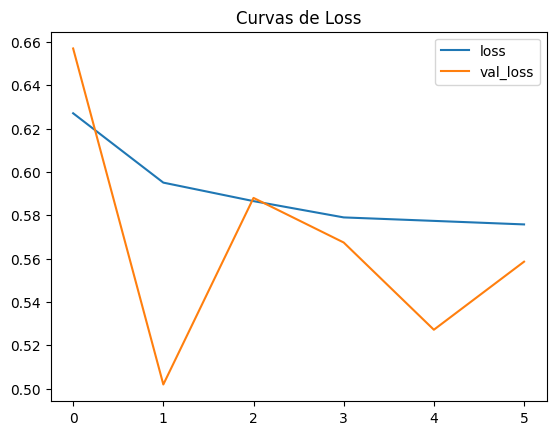

<Figure size 640x480 with 0 Axes>

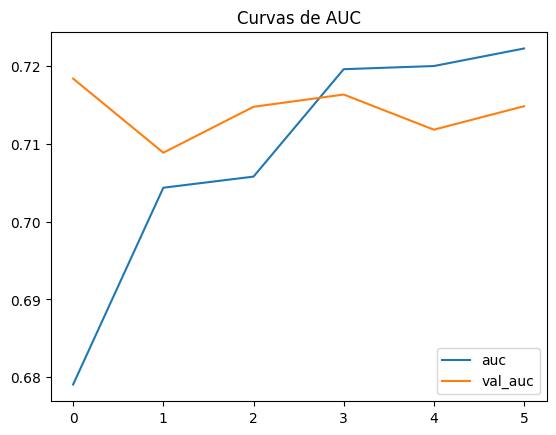

In [11]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

plt.figure()
hist[['loss','val_loss']].plot()
plt.title('Curvas de Loss')

plt.figure()
hist[['auc','val_auc']].plot()
plt.title('Curvas de AUC')


##  Avaliação — Métricas (Precision, Recall, F1, AUC-ROC)

- Predições no **conjunto de validação temporal**.
- **AUC-ROC** ~ 0,71 nesta configuração (sequência=10, 20 features, limites de RAM).
- `classification_report` com **threshold 0,5** (padrão).  
  *Obs.:* Em dados desbalanceados, é comum **Recall** de fraude < Precision; ajuste o **limiar** visando o custo do negócio (curva Precision-Recall).


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
AUC-ROC: 0.7187864342720012
              precision    recall  f1-score   support

           0     0.9814    0.8284    0.8985     23710
           1     0.0899    0.5194    0.1533       774

    accuracy                         0.8187     24484
   macro avg     0.5357    0.6739    0.5259     24484
weighted avg     0.9532    0.8187    0.8749     24484



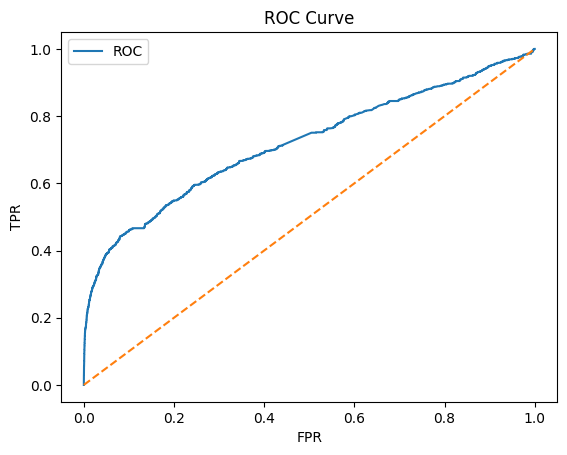

In [12]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support

proba_va = model.predict(X_va, batch_size=2048).ravel()
pred_va = (proba_va >= 0.5).astype(int)

print("AUC-ROC:", roc_auc_score(y_va, proba_va))
print(classification_report(y_va, pred_va, digits=4))

# Curva ROC
fpr, tpr, thr = roc_curve(y_va, proba_va)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.show()


##  Comentários sobre resultados

- **AUC ~ 0,71** sugere separabilidade moderada usando apenas 20 features numéricas e janelas curtas.
- **Trade-off Precision/Recall:** com threshold 0,5 obtivemos alto Precision para a classe 0 e Recall limitado para a classe 1 (fraude).  
  **Próximos passos práticos:**
  - Otimizar **limiar** por F1/Recall ou por **custo esperado**.
  - Testar **mais features/embeddings** para categorias (e.g., `ProductCD`, domínios de email).
  - Melhorar a **engenharia temporal** (agregações recentes vs históricas).
  - Validar com **blocos temporais** e comparar com **LightGBM/XGBoost** (fortes baselines neste desafio).
